In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import GetPeriodicTable, rdchem, rdEHTTools, rdmolops, rdDetermineBonds, AllChem, Draw

from ase.io import read, write


import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch.nn import Parameter
from torch_geometric.nn import MessagePassing, GraphNorm, BatchNorm, LayerNorm
from torch.nn import Parameter, ModuleList, Linear, ReLU, Dropout, MSELoss
from torch_geometric.utils import add_remaining_self_loops, remove_self_loops, softmax
from torch_geometric.utils import remove_self_loops, add_self_loops
import torch.optim as optim

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score, make_scorer, mean_squared_error, r2_score

import copy
from collections import Counter

In [2]:
print("CUDA available:", torch.cuda.is_available())
print("Number of CUDA devices:", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")

CUDA available: True
Number of CUDA devices: 2
Device 0: NVIDIA A100-SXM4-40GB
Device 1: NVIDIA A100-SXM4-40GB


In [7]:
# All data containing 2267 complexes and redox potentials
full_data_df = pd.read_csv('../Data/tmqm_redox_data_full_data.csv')

# Mol and smiles of complexes generated after DFT-redox calculations
final_df = pd.read_pickle('../Data/tmc_frm_xyz2mol_tmqm_all_df.pkl')
final_df = final_df.drop_duplicates(subset='csd_code', keep='first')

In [8]:
full_data_df

,csd_code,q,Stoichiometry,num_atoms,ligands_list,tm_oxs,ligands_q_list,reduction_pot
0,HOLHUO,0,C12H14FeN4O10,41,"['Cc1nc(C(=O)[O-])c(C(=O)O)[nH]1', 'Cc1nc(C(=O...",2,"[-1, -1, 0, 0]",0.645236
1,UPOWOO,0,C17H21Cl2FeN3,44,"['CN1Cc2cccc(c2)CN(C)Cc2cccc(n2)C1', '[Cl-]', ...",2,"[0, -1, -1]",0.147820
2,TACSAU,0,C10H16Cl2FeN4Se2,35,"['Cn1ccn(C)c1=[Se]', 'Cn1ccn(C)c1=[Se]', '[Cl-...",2,"[0, 0, -1, -1]",-0.512239
3,LULSET,0,C11H12FeO3S2,29,"['CC(C)SC(=O)[S-]', '[C-]#[O+]', '[C-]#[O+]', ...",2,"[-1, 0, 0, -1]",0.900510
4,GESMAW,0,C8H3Br5FeO2,19,"['Brc1c(Br)c(Br)[c-](Br)c1Br', '[C-]#[O+]', '[...",2,"[-1, 0, 0, -1]",0.513174
...,...,...,...,...,...,...,...,...
2262,REGPEY,1,C30H26FeNOP2(1+),61,"['[C-]#[O+]', 'c1cc[cH-]c1', 'c1ccc(P(NP(c2ccc...",2,"[0, -1, 0]",1.105673
2263,HIKMIZ,1,C29H33FeNO2P(1+),67,"['CC(C)N(C(C)C)P1C(c2ccccc2)C=CC1c1ccccc1', '[...",2,"[0, 0, 0, -1]",1.560836
2264,SULPAQ,0,C22H21FeNO5Si,51,"['CN(C)Cc1ccccc1O[Si-]1Oc2ccccc2O1', '[C-]#[O+...",2,"[-1, 0, 0, -1]",1.234285
2265,ILOMAZ,0,C17H31FeN3OSi2,55,"['CC([O-])=CC(C)=NCc1ccccn1', 'C[Si](C)(C)[N-]...",2,"[-1, -1]",0.300287


In [10]:
# Filter out rows in final_df
rows_to_delete = []

for idx, row in final_df.iterrows():
    csd = row['csd_code']
    mol = row['mol']

    atoms = mol.GetAtoms()
    max_valence = 0
    Fe_charge = None
    for _, atom in enumerate(atoms):
        max_valence = atom.GetDegree() if atom.GetDegree() > max_valence else max_valence
        if atom.GetSymbol() == 'Fe':
            Fe_charge = atom.GetFormalCharge()

    if max_valence > 7:
        if idx not in rows_to_delete:
            rows_to_delete.append(idx)
    if Fe_charge > 3 or Fe_charge < 0:
        if idx not in rows_to_delete:
            rows_to_delete.append(idx)

# Drop rows from the dataframe
final_df = final_df.drop(rows_to_delete).reset_index(drop=True)

In [12]:
for index, row in final_df.iterrows():
    code = row['csd_code']
    mol = row['mol']
    total_q = 0
    for atom in mol.GetAtoms():
        if atom.GetSymbol() == 'Fe':
            if abs(atom.GetFormalCharge()) > 3:
                print(atom.GetFormalCharge())

In [13]:
count = 0
minus_count = 0
for index, row in final_df.iterrows():
    code = row['csd_code']
    mol = row['mol']
    total_q = 0
    for atom in mol.GetAtoms():
        if atom.GetSymbol() == 'Fe':
            fe_q = atom.GetFormalCharge()
        total_q += atom.GetFormalCharge()
    check_q = full_data_df[full_data_df['csd_code'] == code].q #q_ligants

    if int(total_q) != int(check_q):
        count += 1
        for atom in mol.GetAtoms():
            if atom.GetSymbol() == 'Fe':
                print(f"Atom: {atom.GetSymbol()}, Charge: {atom.GetFormalCharge()}")
        print(count, index, code)
        print(total_q, check_q, fe_q)
    if int(total_q) < 0:
        minus_count += 1
    #break

/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_3711577/702076622.py:13: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if int(total_q) != int(check_q):


# Functions for Graph Generation

In [14]:
# Helper functions

from rdkit import Chem
from rdkit.Chem import AllChem, rdchem, rdFingerprintGenerator


def get_num_Hs(atom):
    """
    Returns the number of hydrogen atoms bonded to the given atom.
    """
    num_Hs = 0
    for neighbor in atom.GetNeighbors():
        if neighbor.GetAtomicNum() == 1:  # Atomic number 1 corresponds to hydrogen
            num_Hs += 1
    return num_Hs

    
def compute_morgan_fingerprint(mol, radius=3, fpSize=2048):
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=radius,fpSize=fpSize)
    morgan_fp = mfpgen.GetFingerprint(mol) # Get the fingerprint object
    # Convert ExplicitBitVect to NumPy array
    np_fp = np.array(list(morgan_fp))#, dtype=float)
    return np_fp # Return the NumPy array

# Creating dataset

# Define constants for hybridizations and stereoisomers
hybridizations = [
            Chem.rdchem.HybridizationType.S,
            Chem.rdchem.HybridizationType.SP,
            Chem.rdchem.HybridizationType.SP2,
            Chem.rdchem.HybridizationType.SP3,
            Chem.rdchem.HybridizationType.SP3D,
            Chem.rdchem.HybridizationType.SP3D2,
            Chem.rdchem.HybridizationType.UNSPECIFIED
        ]

stereos = [rdchem.BondStereo.STEREONONE, rdchem.BondStereo.STEREOANY,
           rdchem.BondStereo.STEREOZ, rdchem.BondStereo.STEREOE]

# Define periodic table for atomic properties
periodic_table = Chem.GetPeriodicTable()


def GenGraphs(df, mfp_mask=None, mfp_radius = 3, mfp_bits = 2048):
    data_list = []
    
    # Mols
    mol_list = df['mol'].tolist()
    
    # Graph features
    #homoE_list = df['HOMO_Energy'].tolist()
    #lumoE_list = df['LUMO_Energy'].tolist()
    #polarize_list = df['Polarizability'].tolist()
    #electronic_E_list = df['Electronic_E'].tolist()
    #dispersion_E_list = df['Dispersion_E'].tolist()

    smiles_list = df['smiles'].tolist()
    
    # target
    y_list = df['y'].tolist()

    
    for idx, mol in enumerate(mol_list):
        
        y = y_list[idx]
        y = torch.tensor(y, dtype=torch.float).view(-1, 1)

        #homoE = torch.tensor([homoE_list[idx]], dtype=torch.float)
        #lumoE = torch.tensor([lumoE_list[idx]], dtype=torch.float)
        #polarize = torch.tensor([polarize_list[idx]], dtype=torch.float)
        #electronic_E = torch.tensor([electronic_E_list[idx]], dtype=torch.float)
        #dispersion_E = torch.tensor([dispersion_E_list[idx]], dtype=torch.float)
    

        smiles = smiles_list[idx]
        
        # Compute Morgan fingerprint
        morgan_fp = compute_morgan_fingerprint(mol, radius=mfp_radius, fpSize=mfp_bits)
        n_features = morgan_fp.shape[0]
        if mfp_mask is None:
            mfp_mask = np.ones(n_features, dtype=bool)
        morgan_fp = morgan_fp[mfp_mask]
        morgan_fp_tensor = torch.tensor(list(morgan_fp), dtype=torch.float)
        #print(sum(morgan_fp_tensor), len(morgan_fp_tensor))

        #mol = Chem.MolFromSmiles(smiles)
        #if mol is None:
        #    continue  # Skip invalid SMILES

        

        # Add hydrogens
        
        #mol = Chem.AddHs(mol)
        
        atoms = mol.GetAtoms()
        max_valence = 0
        for _, atom in enumerate(atoms):
            max_valence = atom.GetDegree() if atom.GetDegree() > max_valence else max_valence
            if atom.GetSymbol() == 'Fe':
                Fe_charge = torch.tensor([atom.GetFormalCharge()], dtype=torch.float)
        
        if max_valence > 7:
            continue
        if Fe_charge > 3 or Fe_charge < 0:
            continue

        conformer = mol.GetConformer() # Get the default conformer
        pos = [conformer.GetAtomPosition(atom.GetIdx()) for atom in mol.GetAtoms()]
        pos = torch.tensor(pos, dtype=torch.float)
        
        xs = []
        Fe_neigh_symbols = [0] * 92
        Fe_neigh_charge = 0
        for atom in atoms:
            atomic_num_scaled = float((atom.GetAtomicNum() - 1) / 91)  # H: 1, U: 92
            symbol = [0] * 92 #len(periodic_table.GetMaxAtomicNumber())
            try:
                symbol[periodic_table.GetAtomicNumber(atom.GetSymbol()) - 1] = 1.
            except IndexError:
                continue
            
            if atom.GetSymbol() == 'Fe':
                Fe_charge = torch.tensor([atom.GetFormalCharge()], dtype=torch.float)
                # Get neighbors of the Fe atom
                neighbors = atom.GetNeighbors()
                for neighbor in neighbors:
                    # Get the symbol of the neighbor atom
                    neigh_symbol = neighbor.GetSymbol()
                    # Append the symbol to the list
                    try:
                        Fe_neigh_symbols[periodic_table.GetAtomicNumber(neigh_symbol) - 1] = 1.
                    except IndexError:
                        continue
                    Fe_neigh_charge += neighbor.GetFormalCharge()
                
                Fe_neigh_charge = torch.tensor([Fe_neigh_charge], dtype=torch.float)
                Fe_neigh_symbols = torch.tensor(Fe_neigh_symbols, dtype=torch.float)
            
            #print(atom.GetSymbol(), atom.GetFormalCharge(), atom.GetDegree(), atom.GetHybridization(), atom.GetTotalNumHs())
            valance = [0.] * 8
            valance[atom.GetDegree()] = 1.

            formal_charge = atom.GetFormalCharge()   # [-3, -2, -1, 0, 1, 2, 3]
            radical_electrons = atom.GetNumRadicalElectrons()
            
            hybridization = [0.] * len(hybridizations)
            if atom.GetHybridization() in hybridizations:
                hybridization[hybridizations.index(atom.GetHybridization())] = 1.
                
            aromaticity = 1. if atom.GetIsAromatic() else 0.
            hydrogens = [0.] * 5
            try:
                hydrogens[get_num_Hs(atom)] = 1.
            except IndexError: # Handle cases with > 4 explicit Hs if possible
                 print(f"Warning: Atom {atom.GetIdx()} in mol {idx} has unexpected num Hs {get_num_Hs(atom)}.")
            #print(atom.GetSymbol(), hydrogens)
            
            '''chirality = 1. if atom.HasProp('_ChiralityPossible') else 0.
            chirality_type = [0.] * 2
            if atom.HasProp('_CIPCode'):
                try:
                    chirality_type[['R', 'S'].index(atom.GetProp('_CIPCode'))] = 1.
                except ValueError:
                    continue'''

            atomic_mass = float((periodic_table.GetAtomicWeight(atom.GetAtomicNum()) - 1.008) / 237.021)
            vdw_radius = float((periodic_table.GetRvdw(atom.GetAtomicNum()) - 1.2) / 1.35)
            covalent_radius = float((periodic_table.GetRcovalent(atom.GetAtomicNum()) - 0.23) / 1.71)

            x = torch.tensor([atomic_num_scaled] + symbol + valance +
                             [formal_charge] + [radical_electrons] +
                             hybridization + [aromaticity] +
                             hydrogens + #[chirality] + chirality_type +
                             [atomic_mass] +
                             [vdw_radius] + [covalent_radius], dtype=torch.float)
            xs.append(x)

        x = torch.stack(xs, dim=0) if len(xs) > 0 else torch.tensor([], dtype=torch.float)

        atomic_numbers = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
        z = torch.tensor(atomic_numbers, dtype=torch.long) if atomic_numbers else torch.tensor([], dtype=torch.long)

        # --- Assertion Checks --- #
        num_atoms_pos = pos.shape[0]
        num_atoms_z = z.shape[0]
        assert num_atoms_pos == num_atoms_z, \
                                f"CRITICAL MISMATCH: num_atoms_pos ({num_atoms_pos}) != num_atoms_z ({num_atoms_z}) for molecule {idx}" # Replace mol_identifier with SMILES or I

        row, col, edge_attrs = [], [], []

        for bond in mol.GetBonds():
            start = bond.GetBeginAtomIdx()
            end = bond.GetEndAtomIdx()

            row += [start, end]
            col += [end, start]

            bond_type = bond.GetBondType()
            single = 1. if bond_type == Chem.rdchem.BondType.SINGLE else 0.
            double = 1. if bond_type == Chem.rdchem.BondType.DOUBLE else 0.
            triple = 1. if bond_type == Chem.rdchem.BondType.TRIPLE else 0.
            dative = 1. if bond_type == Chem.rdchem.BondType.DATIVE else 0.

            conjugated = 1. if bond.GetIsConjugated() else 0.
            ring_bond = 1. if bond.IsInRing() else 0.

            stereo = [0.] * len(stereos)
            if bond.GetStereo() in stereos:
                stereo[stereos.index(bond.GetStereo())] = 1.

            edge_attr = torch.tensor([single, double, triple, dative,
                                      conjugated, ring_bond] + stereo, dtype=torch.float)
            
            edge_attrs += [edge_attr, edge_attr]

        edge_index = torch.tensor([row, col], dtype=torch.long) if len(row) > 0 else torch.tensor([], dtype=torch.long).view(2, -1)
        edge_attr = torch.stack(edge_attrs, dim=0) if len(edge_attrs) > 0 else torch.tensor([], dtype=torch.float)

        # Debugging: Print shapes and contents
        #print(f"edge_index shape: {edge_index.shape}")
        #print(f"edge_attr shape: {edge_attr.shape}")
        
        # Sort indices.
        if edge_index.numel() > 0:
            perm = (edge_index[0] * x.size(0) + edge_index[1]).argsort()
            edge_index, edge_attr = edge_index[:, perm], edge_attr[perm]

        data = Data(x=x, z=z, pos=pos, edge_index=edge_index, edge_attr=edge_attr, y=y,
                    metal_charge=Fe_charge, metal_neigh_symbols=Fe_neigh_symbols, metal_neigh_charge=Fe_neigh_charge,
                    morgan_fp=morgan_fp_tensor, smiles=smiles)
                    #electronic_E=electronic_E, dispersion_E=dispersion_E, 
                    #pca_0=pca_0, pca_1=pca_1, tsne_0=tsne_0, tsne_1=tsne_1, smiles=smiles) homoE= homoE, lumoE=lumoE, polarize=polarize, )
        

        data_list.append(data)
        

    return data_list

# Model

In [ ]:
# Updated Final Model Version

import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter, ModuleList, Linear, Identity, Dropout
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.nn import GraphNorm, LayerNorm, BatchNorm
from torch_geometric.utils import add_remaining_self_loops, add_self_loops, remove_self_loops, softmax
from torch_geometric.nn.conv.gcn_conv import gcn_norm


# Helper functions for parameter initialization
def glorot(tensor):
    if tensor is not None:
        torch.nn.init.xavier_uniform_(tensor)

def zeros(tensor):
    if tensor is not None:
        torch.nn.init.zeros_(tensor)

# --- Configuration (Essential for RexGCNConv) ---
class CFG:
    class gnn:
        normalize_adj = True # Normalize or not
        self_msg = 'none'  # Options: 'none', 'add', 'concat'
        agg = 'add' # GCN uses 'add'
        msg_direction = 'single' 

cfg = CFG()


class RexGCNConv(MessagePassing):
    r""" General RexGCN Layer
    """
    def __init__(self, in_channels:int, out_channels:int, edge_dim:int, improved:bool=False, bias:bool=True,**kwards):
        super(RexGCNConv, self).__init__(aggr='add', **kwards)  # "Add" aggregation.
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.improved = improved
        self.normalize = cfg.gnn.normalize_adj

        self.weight = torch.nn.Parameter(torch.Tensor(in_channels, out_channels))
        self.edge_updated = torch.nn.Parameter(torch.Tensor(out_channels + edge_dim, out_channels))  # new property of GCN
        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters() # Calls glorot/zeros below

    def reset_parameters(self):
        glorot(self.weight) 
        glorot(self.edge_updated) 
        zeros(self.bias)

    def forward(self, x: torch.Tensor, edge_index, edge_attr: torch.Tensor, edge_weight=None):
        '''
        x : node feature matrix that has shape [N, in_channels]
        edge_index : connectivity, Adj list in the edge index has shape [2, E]
        edge_attr: E-dimensional edge feature matrix that has shape [ E x edge_dim]
        '''
        # Linearly transform node feature matrix  (XΘ)
        x = torch.matmul(x, self.weight)

        edge_index_prop = edge_index # Start with original edge_index
        edge_attr_prop = edge_attr   # Start with original edge_attr
        norm = edge_weight           # Default norm is None or passed-in edge_weight

        if self.normalize:
            edge_index_norm, norm = gcn_norm(
                                            edge_index, 
                                            edge_weight, 
                                            x.size(self.node_dim),
                                            improved=self.improved,
                                            add_self_loops=True,
                                            dtype=x.dtype
                                        )
            edge_index_prop = edge_index_norm # Use normalized edge_index for propagation
            # Need edge_attr corresponding to edge_index_norm (i.e., with self-loop attrs)
            num_nodes = x.size(self.node_dim)
            self_loop_edges_attr = torch.zeros(num_nodes, edge_attr.size(1),
                                              dtype=edge_attr.dtype, device=edge_index.device)
            # Assuming add_remaining_self_loops appends loops at the end:
            edge_attr_prop = torch.cat([edge_attr, self_loop_edges_attr], dim=0)
        else:
            # No normalization case
            num_nodes = x.size(self.node_dim)
            self_loop_edges_attr = torch.zeros(num_nodes, edge_attr.size(1),
                                              dtype=edge_attr.dtype, device=edge_index.device)
            edge_attr_prop = torch.cat([edge_attr, self_loop_edges_attr], dim=0)

            edge_index_prop, _ = add_self_loops(edge_index, num_nodes=num_nodes)

            norm = edge_weight # norm remains None or edge_weight



        # Start propagating messages
        # Pass the prepared edge_index_prop, edge_attr_prop, and norm
        # Use x.size(self.node_dim) or equivalent for size
        x_msg =  self.propagate(edge_index_prop, x=x, edge_attr=edge_attr_prop, norm=norm) #, size=x.size(self.node_dim))

        # Handle self_msg based on config
        if cfg.gnn.self_msg == 'none':
            return x_msg
        elif cfg.gnn.self_msg == 'add':
            return x_msg + x # Add **transformed** input features (XΘ)
        elif cfg.gnn.self_msg == 'concat':
            return torch.cat([x_msg, x], dim=-1) # Concat with **transformed** input features
        else:
            raise ValueError('self_msg {} not defined'.format(
                cfg.gnn.self_msg))

    def message(self, x_j, edge_attr, norm):
        # x_j: neighbor node features [E (+N), out_channels]
        # edge_attr: edge features [E (+N), edge_dim]
        if edge_attr is not None:
            # Ensure shapes match before cat
            # This assumes edge_attr corresponds row-wise to x_j after propagate setup
            msg = torch.cat([x_j, edge_attr], dim=-1)   # (E (+N)) x (out_channels + edge_dim)
        else:
            msg = x_j

        if norm is not None:
            # norm should have shape [E (+N)]
            return norm.view(-1, 1) * msg
        else:
            return msg

    def update(self, aggr_out):   # Return node embeddings
        # aggr_out: [N, out_channels + edge_dim] if edge_attr included in message, else [N, out_channels]
        # Based on message(), it includes edge_attr, so shape is [N, out_channels + edge_dim]
        aggr_out = torch.mm(aggr_out, self.edge_updated) # [N, out_channels]
        if self.bias is not None:
            return aggr_out + self.bias
        else:
            return aggr_out

    def __repr__(self):
        return '{}({}, {}, {})'.format(self.__class__.__name__, self.in_channels, self.out_channels, self.edge_dim)



# --- RexGCN Model ---
class RexGCN(torch.nn.Module):

    def __init__(self, node_features, hidden_dim, edge_features, dropout, num_conv_layers, num_fc_layers, norm_type='layer'):
        super(RexGCN, self).__init__()
        self.node_features = node_features
        self.hidden_dim = hidden_dim
        self.edge_features = edge_features
        self.dropout_rate = dropout
        self.num_conv_layers = num_conv_layers
        self.num_fc_layers = num_fc_layers
        self.norm_type = norm_type.lower() if isinstance(norm_type, str) else 'none'
        # No add_residual flag or input_proj needed

        self.conv_list = ModuleList()
        self.norm_list = ModuleList()

        # --- GNN Layers ---
        current_dim = node_features
        for i in range(num_conv_layers):
            self.conv_list.append(
                RexGCNConv(current_dim, hidden_dim, edge_features) # Bias=True is default
            )

            # --- Conditionally create normalization layer ---
            if self.norm_type == 'layer':
                self.norm_list.append(LayerNorm(hidden_dim))
            elif self.norm_type == 'graph':
                self.norm_list.append(GraphNorm(hidden_dim)) # Requires PyG GraphNorm
            elif self.norm_type == 'batch':
                 self.norm_list.append(BatchNorm(hidden_dim))
            elif self.norm_type is None or self.norm_type.lower() == 'none':
                 self.norm_list.append(Identity()) # No normalization
            else:
                raise ValueError(f"Unsupported norm_type: {self.norm_type}")

            current_dim = hidden_dim # Input dim for next layer is output dim of current

        # --- FC Layers ---
        self.fc_list = ModuleList()
        fc_input_dim = hidden_dim * 2 # Assuming pooling remains cat(gmp, gap)
        current_fc_dim = fc_input_dim
        for i in range(num_fc_layers - 1):
            self.fc_list.append(Linear(current_fc_dim, hidden_dim*2))
            current_fc_dim = hidden_dim*2

        self.fc_out = Linear(current_fc_dim, 1)
        self.dropout = Dropout(p=self.dropout_rate)


    def forward(self, data):
        x, edge_index, batch_index, edge_attr = data.x, data.edge_index, data.batch, data.edge_attr

        # GNN Layers
        for i in range(self.num_conv_layers):
            # Apply GCN convolution
            x = self.conv_list[i](x, edge_index, edge_attr)

            # Apply activation, dropout, normalization
            x = F.relu(x)
            x = self.dropout(x)

            if i < len(self.norm_list):
                norm = self.norm_list[i]
                if self.norm_type in ['graph', 'layer']:
                     x = norm(x, batch_index)
                elif self.norm_type == 'batch':
                     x = norm(x)
                else: # Identity
                     x = norm(x)
            # No residual addition here

        # Global Pooling
        x_pooled = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)

        # FC Layers
        x = x_pooled
        for i in range(self.num_fc_layers - 1):
            x = self.fc_list[i](x)
            x = F.relu(x)
            x = self.dropout(x)

        # Output Layer
        x = self.fc_out(x)
        return x


# Train Functions

In [17]:
# Calculating mfp PCA and tsne
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from skmatter.preprocessing import StandardFlexibleScaler
from rdkit.Chem import AllChem, rdchem, rdFingerprintGenerator
import sklearn.ensemble

def get_rf_feature_mask(x: np.ndarray,
                        y: np.ndarray,
                        n_features: int = None,
                        rf_model: sklearn.ensemble.RandomForestRegressor = None,
                        **rf_params) -> np.ndarray:
    """
    Trains a RandomForestRegressor and returns a boolean mask for the
    top 'n_features' most important features.

    Args:
        x (np.ndarray): Input features (e.g., fingerprints), shape (n_samples, n_original_features).
        y (np.ndarray): Target variable, shape (n_samples,).
        n_features (int, optional): The number of top features to select.
            If None or >= x.shape[1], a mask selecting all features is returned.
            Defaults to None.
        rf_model (RandomForestRegressor, optional): A pre-initialized
            RandomForestRegressor instance. If None, a new one is created.
            Defaults to None.
        **rf_params: Additional keyword arguments passed to the
                     RandomForestRegressor constructor if rf_model is None
                     (e.g., n_estimators=100, random_state=42).

    Returns:
        np.ndarray: A boolean mask of shape (n_original_features,) where True
                    indicates a selected feature.

    Raises:
        ValueError: If n_features is greater than the number of features in x.
    """
    n_samples, n_original_features = x.shape

    if n_features is None:
        n_features = n_original_features # Select all if None
        print(f"n_features not specified, selecting all {n_original_features} features.")

    if n_features > n_original_features:
        raise ValueError(f'n_features={n_features} cannot be larger than '
                         f'the original number of features ({n_original_features})')
    elif n_features == n_original_features:
        print(f"n_features ({n_features}) equals original features. Selecting all.")
        return np.ones(n_original_features, dtype=bool)
    else:
        # --- Core RF Feature Selection ---
        print(f"Selecting top {n_features} features using RandomForestRegressor...")
        if rf_model is None:
            # Provide sensible defaults or allow passing via **rf_params
            rf_params_default = {'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}
            rf_params_default.update(rf_params) # Overwrite defaults with user params
            print(f"  Creating RandomForestRegressor with params: {rf_params_default}")
            rf = sklearn.ensemble.RandomForestRegressor(**rf_params_default)
        else:
            print("  Using provided RandomForestRegressor model.")
            rf = rf_model

        # Ensure y is 1D array for RF regressor
        if y.ndim > 1 and y.shape[1] == 1:
            y = y.ravel()

        rf.fit(x, y)
        importances = rf.feature_importances_

        # Get indices of top k features (indices sorted by importance descending)
        # Using np.argsort directly on negative importance
        indices = (-importances).argsort()[:n_features]

        # Create boolean mask
        mask = np.zeros(n_original_features, dtype=bool)
        mask[indices] = True
        print(f"  Generated mask selecting {mask.sum()} features.")
        return mask
    

def get_masked_mfp(mfp_full, y, n_features, random_state=42):
    mask = get_rf_feature_mask(mfp_full, y, n_features=n_features, random_state=random_state)
    return mfp_full[:, mask]

def pca_from_mfp(mfp_descriptors, y=None, n_components=2, n_features=-1):
    pca = PCA(n_components=n_components, copy=False)
    if n_features == -1:
        mfp_pca = pca.fit_transform(mfp_descriptors)
    elif n_features > -1:
        if y is not None:
            mfp_pca = pca.fit_transform(get_masked_mfp(mfp_descriptors, y, n_features))
        else:
            print('Provide target y')
            return None
    else:
        print('n_features must be -1 or above')
        return None
    return mfp_pca

def tsne_from_mfp(mfp_descriptors, y=None, n_components=2, n_features=-1):
    tsne = TSNE(n_components=2, random_state=42)
    if n_features == -1:
        mfp_tsne = tsne.fit_transform(mfp_descriptors)
    elif n_features > -1:
        if y is not None:
            mfp_tsne = tsne.fit_transform(get_masked_mfp(mfp_descriptors, y, n_features))
        else:
            print('Provide target y')
            return None
    else:
        print('n_features must be -1 or above')
        return None
    return mfp_tsne

def compute_morgan_fingerprint(mol, radius=3, fpSize=2048):
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=radius,fpSize=fpSize)
    morgan_fp = mfpgen.GetFingerprint(mol) # Get the fingerprint object
    # Convert ExplicitBitVect to NumPy array
    np_fp = np.array(list(morgan_fp))#, dtype=float)
    return np_fp # Return the NumPy array

In [18]:
from torch.optim.lr_scheduler import _LRScheduler
from typing import Dict, Iterator, List, Optional, Union, OrderedDict, Tuple

class NoamLR(_LRScheduler):
    """
    Noam learning rate scheduler with piecewise linear increase and exponential decay.

    The learning rate increases linearly from init_lr to max_lr over the course of
    the first warmup_steps (where :code:`warmup_steps = warmup_epochs * steps_per_epoch`).
    Then the learning rate decreases exponentially from :code:`max_lr` to :code:`final_lr` over the
    course of the remaining :code:`total_steps - warmup_steps` (where :code:`total_steps =
    total_epochs * steps_per_epoch`). This is roughly based on the learning rate
    schedule from `Attention is All You Need <https://arxiv.org/abs/1706.03762>`_, section 5.3.
    """
    def __init__(self,
                 optimizer: 'Optimizer',
                 warmup_epochs: List[Union[float, int]],
                 total_epochs: List[int],
                 steps_per_epoch: int,
                 init_lr: List[float],
                 max_lr: List[float],
                 final_lr: List[float]):

        assert len(optimizer.param_groups) == len(warmup_epochs) == len(total_epochs) == len(init_lr) == \
               len(max_lr) == len(final_lr)

        self.num_lrs = len(optimizer.param_groups)

        self.optimizer = optimizer
        self.warmup_epochs = np.array(warmup_epochs)
        self.total_epochs = np.array(total_epochs)
        self.steps_per_epoch = steps_per_epoch
        self.init_lr = np.array(init_lr)
        self.max_lr = np.array(max_lr)
        self.final_lr = np.array(final_lr)

        self.current_step = 0
        self.lr = init_lr
        self.warmup_steps = (self.warmup_epochs * self.steps_per_epoch).astype(int)
        self.total_steps = self.total_epochs * self.steps_per_epoch
        self.linear_increment = (self.max_lr - self.init_lr) / self.warmup_steps

        self.exponential_gamma = (self.final_lr / self.max_lr) ** (1 / (self.total_steps - self.warmup_steps))

        super(NoamLR, self).__init__(optimizer)

    def get_lr(self) -> List[float]:
        return list(self.lr)

    def step(self, current_step: int = None):
        if current_step is not None:
            self.current_step = current_step
        else:
            self.current_step += 1

        for i in range(self.num_lrs):
            if self.current_step <= self.warmup_steps[i]:
                self.lr[i] = self.init_lr[i] + self.current_step * self.linear_increment[i]
            elif self.current_step <= self.total_steps[i]:
                self.lr[i] = self.max_lr[i] * (self.exponential_gamma[i] ** (self.current_step - self.warmup_steps[i]))
            else:  # theoretically this case should never be reached since training should stop at total_steps
                self.lr[i] = self.final_lr[i]

            self.optimizer.param_groups[i]['lr'] = self.lr[i]




In [21]:
# Training functions

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

class RmseLoss(torch.nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        # Instantiate the MSELoss module. It defaults to reduction='mean'
        self.mse = torch.nn.MSELoss()
        self.eps = eps # Epsilon for numerical stability near sqrt(0)

    def forward(self, y_pred, y_true):
        # Ensure y_true has the same shape as y_pred for MSE calculation
        # This is crucial if y_pred is e.g., [N, 1] and y_true is [N]
        y_true = y_true.view_as(y_pred)

        # Calculate MSE loss (averaged over the batch by default)
        loss_mse = self.mse(y_pred, y_true)
        # Calculate RMSE
        loss_rmse = torch.sqrt(loss_mse + self.eps)

        return loss_rmse
    

rmse_loss = RmseLoss() # Instantiate your custom loss

def train(train_loader, model, optimizer, scheduler, loss_type='mse'):
    model.train()
    train_loss=0
    for data in train_loader:
        data = data.to(device)
        model.zero_grad()
        y_pred = model(data) #(data.x, data.edge_index, data.batch,data.edge_attr)
        if loss_type == 'mse':
            loss_train = F.mse_loss(y_pred, data.y)   # rmse_loss(y_pred, data.y) #
            loss_train.backward()
        elif loss_type == 'rmse':
            loss_train = rmse_loss(y_pred, data.y)
            loss_train.backward()
        optimizer.step()
        if isinstance(scheduler, NoamLR):
            scheduler.step()
        train_loss += float(loss_train) * data.num_graphs
    return train_loss / len(train_loader.dataset)

def train_rmse(train_loader,model, optimizer, scheduler,):
    model.train()
    train_loss=0
    for data in train_loader:
        data = data.to(device)
        model.zero_grad()
        y_pred = model(data) #(data.x, data.edge_index, data.batch,data.edge_attr)
        loss_train = rmse_loss(y_pred, data.y) #
        loss_train.backward()
        optimizer.step()
        if isinstance(scheduler, NoamLR):
            scheduler.step()
        train_loss += float(loss_train) * data.num_graphs
    return train_loss / len(train_loader.dataset)


def evaluate(loader, model):
    model.eval()
    test_loss=0
    for data_t in loader:
        data_t = data_t.to(device)
        with torch.no_grad():
            out = model(data_t) #(data_t.x, data_t.edge_index, data_t.batch,data_t.edge_attr)
            loss_test = F.mse_loss(out, data_t.y)
        test_loss += float(loss_test) * data_t.num_graphs
    return test_loss / len(loader.dataset)


def evaluate_rmse(loader, model):
    model.eval()
    test_loss=0
    for data_t in loader:
        data_t = data_t.to(device)
        with torch.no_grad():
            out = model(data_t) #(data_t.x, data_t.edge_index, data_t.batch,data_t.edge_attr)
            loss_test = rmse_loss(out, data_t.y)
        test_loss += float(loss_test) * data_t.num_graphs
    return test_loss / len(loader.dataset)

cuda:0


# K-fold CV (3,5)

In [20]:
# --- Model Setup ---

class TrainArgsGCN:
    def __init__(self,
                 edge_features=None,  # Provide default values
                 num_features=None,   # Provide default values
                 dropout=0.1,
                 norm_type='layer',
                 num_conv_layers=3,
                 num_fc_layers=5,
                 hidden_dim=512,
                 batch_size=128,
                 init_lr=1e-4,
                 max_lr=1e-3,
                 final_lr=1e-4,
                 num_lrs=1,
                 warmup_epochs=2.0,
                 epochs=200,
                 patience=50):
        # Assign arguments to instance attributes
        self.edge_features = edge_features
        self.num_features = num_features
        self.dropout = dropout
        self.norm_type = norm_type
        self.num_conv_layers = num_conv_layers
        self.num_fc_layers = num_fc_layers
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.init_lr = init_lr
        self.max_lr = max_lr
        self.final_lr = final_lr
        self.num_lrs = num_lrs
        self.warmup_epochs = warmup_epochs
        self.epochs = epochs
        self.patience = patience


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import copy
import matplotlib.pyplot as plt
import torch.optim as optim
from collections import Counter
import math # For loss plot adjustment
import copy

print("--- Preparing for K-Fold Cross-Validation on Entire Dataset ---")
labels_for_stratification = []
for data in final_df.y:
    y_value = data
    if y_value < 0:
        labels_for_stratification.append(-1)
    else:
        labels_for_stratification.append(1)

print(f"Extracted {len(labels_for_stratification)} labels for stratification.")
print("Original Label Distribution:", Counter(labels_for_stratification))

indices = np.array(list(range(len(final_df)))) # Use NumPy array for easier indexing with KFold output
labels_for_stratification = np.array(labels_for_stratification) # Also NumPy array

# --- K-Fold Cross-Validation Setup ---

k_folds = 5 # Number of folds (e.g., 5 or 10)
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Lists to store metrics from each fold
fold_best_val_rmses = []
fold_best_val_mses = [] # Store best validation MSE for each fold
all_train_losses_cv = [] # Store training losses for each fold
all_val_losses_cv = []   # Store validation losses for each fold
all_val_losses_cv_rmse = []   # Store validation losses for each fold

print(f'\n--- Starting {k_folds}-Fold Cross-Validation ---')

# --- K-Fold Loop ---
# Use the full indices and labels for splitting
for fold, (train_fold_idx, val_fold_idx) in enumerate(skf.split(indices, labels_for_stratification)):
    print(f'\n===== Fold {fold+1}/{k_folds} =====')

    # --- Get Original Indices for this Fold (Directly from KFold output) ---
    original_train_fold_indices = indices[train_fold_idx]
    original_val_fold_indices = indices[val_fold_idx]

    # --- Create Data for this Fold ---

    # get train df
    train_fold_df = final_df.iloc[original_train_fold_indices]
    # get mask for mfp from train data
    target_y = train_fold_df['y'].values
    descriptors = None
    for i,mol in enumerate(train_fold_df['mol']):
        x = compute_morgan_fingerprint(mol)
        if i == 0:
            descriptors = np.zeros((len(train_fold_df), x.shape[-1]))
        descriptors[i]=x
    mfp_descriptors_scaled_full = StandardFlexibleScaler(column_wise=False).fit_transform(descriptors)
    mfp_mask_128 = get_rf_feature_mask(mfp_descriptors_scaled_full, target_y, n_features=128, random_state=42)
    
    # get val df
    val_fold_df = final_df.iloc[original_val_fold_indices]
    
    # Generate graph data
    train_fold_data = GenGraphs(train_fold_df, mfp_mask=mfp_mask_128) #[graph_data[i] for i in original_train_fold_indices]
    val_fold_data = GenGraphs(val_fold_df, mfp_mask=mfp_mask_128) #[graph_data[i] for i in original_val_fold_indices]
    
    num_node_features = train_fold_data[0].x.size(1)
    num_edge_features = train_fold_data[0].edge_attr.size(1)
    print(f"Number of node features: {num_node_features}")
    print(f"Number of edge features: {num_edge_features}")
    print(f'Fold {fold+1} - Train size: {len(train_fold_data)}, Validation size: {len(val_fold_data)}')

    # train args
    args = TrainArgsGCN(edge_features = num_edge_features, num_features = num_node_features)

    # --- Create DataLoaders for this Fold ---
    train_fold_loader = DataLoader(train_fold_data, batch_size=args.batch_size, shuffle=True)
    val_fold_loader = DataLoader(val_fold_data, batch_size=args.batch_size, shuffle=False)

    # --- Re-initialize Model, Optimizer, and Scheduler for each fold ---
    print(f'Fold {fold+1} - Initializing model, optimizer, scheduler...')
    model = RexGCN(node_features=args.num_features,
                   hidden_dim=args.hidden_dim,
                   edge_features=args.edge_features,
                   norm_type=args.norm_type,
                   dropout=args.dropout,
                   num_fc_layers=args.num_fc_layers,
                   num_conv_layers=args.num_conv_layers
                   ).to(device)

    params = [{'params': model.parameters(), 'lr': args.init_lr, 'weight_decay': 0}]
    optimizer = optim.Adam(params)
    criterion = torch.nn.MSELoss()
    rmse_loss = RmseLoss()

    scheduler = NoamLR(
        optimizer=optimizer,
        warmup_epochs=[args.warmup_epochs],
        total_epochs=[args.epochs] * args.num_lrs,
        steps_per_epoch=len(train_fold_loader) // args.batch_size,
        init_lr=[args.init_lr],
        max_lr=[args.max_lr],
        final_lr=[args.final_lr]
    )

    # --- Training Loop for this Fold ---
    patience = args.patience
    best_val_loss_fold = float('inf')
    patience_counter_fold = 0
    best_model_state_fold = None 
    best_epoch_fold = -1

    train_losses_fold = []
    val_losses_fold = [] # Store MSE
    val_losses_rmse_fold = [] # Store RMSE

    print(f'Fold {fold+1} - Starting training...')
    for epoch in range(1, args.epochs + 1):
        # Use MSE for training gradients, RMSE for validation metric
        train_loss = train(train_fold_loader, model=model, optimizer=optimizer, scheduler=scheduler, loss_type='mse') 
        val_loss_mse = evaluate(val_fold_loader, model=model) 
        val_loss_rmse = evaluate_rmse(val_fold_loader, model=model) 
        current_val_loss = val_loss_rmse # Use RMSE for early stopping

        train_losses_fold.append(train_loss)
        val_losses_fold.append(val_loss_mse)
        val_losses_rmse_fold.append(val_loss_rmse)

        if epoch % 10 == 0 or epoch == 1: # Print less frequently
            print(f'  Epoch: {epoch:d}, Loss - Train: {train_loss:.5f}, Val MSE: {val_loss_mse:.5f}, Val RMSE: {val_loss_rmse:.5f}')

        # --- Early Stopping Check for this Fold ---
        improved = False
        if current_val_loss < best_val_loss_fold:
            best_val_loss_fold = current_val_loss
            improved = True

        if improved:
            patience_counter_fold = 0
            best_model_state_fold = copy.deepcopy(model.state_dict())
            best_epoch_fold = epoch
            # print(f'    -> Fold {fold+1} Val loss improved to {best_val_loss_fold:.5f}. Saving state.')
        else:
            patience_counter_fold += 1
            # print(f'    -> Fold {fold+1} Val metric did not improve. Patience: {patience_counter_fold}/{patience}')

        #if patience_counter_fold >= patience:
        #    print(f'  !!! Fold {fold+1} Early stopping triggered after epoch {epoch}. Best epoch was {best_epoch_fold} with Val RMSE: {best_val_loss_fold:.5f}')
        #    break

    # --- Store performance for this fold ---
    # We store the best validation RMSE achieved during this fold's training
    if best_epoch_fold != -1: # Check if training improved at all
         fold_best_val_rmses.append(best_val_loss_fold)
         fold_best_val_mses.append(val_losses_fold[best_epoch_fold - 1]) # Store MSE at best epoch
         print(f'Fold {fold+1} - Finished. Best Validation RMSE: {best_val_loss_fold:.5f} (at Epoch {best_epoch_fold})')
         print(f'Fold {fold+1} - Best Validation MSE: {val_losses_fold[best_epoch_fold - 1]:.5f} (at Epoch {best_epoch_fold})')
    else:
         print(f'Fold {fold+1} - Finished. Validation loss did not improve.')
         # Decide how to handle this: append NaN, append last loss, or skip? NaN is often best for averaging.
         fold_best_val_rmses.append(float('nan'))

    # Store losses for plotting average curves
    all_train_losses_cv.append(train_losses_fold)
    all_val_losses_cv.append(val_losses_fold)
    all_val_losses_cv_rmse.append(val_losses_rmse_fold)



# --- Aggregate and Report Results ---
print('\n--- Cross-Validation Summary ---')

# Calculate average and std dev of the *best validation RMSE* achieved in each fold
avg_val_rmse = np.nanmean(fold_best_val_rmses)
std_val_rmse = np.nanstd(fold_best_val_rmses)

avg_val_mse = np.nanmean(fold_best_val_mses)
std_val_mse = np.nanstd(fold_best_val_mses)

print(f'Average Best Validation RMSE across {k_folds} folds: {avg_val_rmse:.5f} ± {std_val_rmse:.5f}')
print(f'Average Best Validation MSE across {k_folds} folds: {avg_val_mse:.5f} ± {std_val_mse:.5f}')

print('\nIndividual Fold Best Validation RMSEs (MSEs):')
for i, rmse in enumerate(fold_best_val_rmses):
    print(f'  Fold {i+1}: {rmse:.5f} (MSE: {fold_best_val_mses[i]:.5f})')


--- Preparing for K-Fold Cross-Validation on Entire Dataset ---
Extracted 1803 labels for stratification.
Original Label Distribution: Counter({1: 1481, -1: 322})

--- Starting 5-Fold Cross-Validation ---

===== Fold 1/5 =====


/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Selecting top 128 features using RandomForestRegressor...
  Creating RandomForestRegressor with params: {'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}
  Generated mask selecting 128 features.
Number of node features: 119
Number of edge features: 10
Fold 1 - Train size: 1442, Validation size: 361
Fold 1 - Initializing model, optimizer, scheduler...


/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_3711577/4223129709.py:41: RuntimeWarning: divide by zero encountered in divide
  self.linear_increment = (self.max_lr - self.init_lr) / self.warmup_steps
/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_3711577/4223129709.py:43: RuntimeWarning: divide by zero encountered in divide
  self.exponential_gamma = (self.final_lr / self.max_lr) ** (1 / (self.total_steps - self.warmup_steps))


Fold 1 - Starting training...
  Epoch: 1, Loss - Train: 0.41642, Val MSE: 0.27247, Val RMSE: 0.51794
  Epoch: 10, Loss - Train: 0.15810, Val MSE: 0.17166, Val RMSE: 0.41300
  Epoch: 20, Loss - Train: 0.13575, Val MSE: 0.13324, Val RMSE: 0.35846
  Epoch: 30, Loss - Train: 0.10606, Val MSE: 0.12869, Val RMSE: 0.35273
  Epoch: 40, Loss - Train: 0.07060, Val MSE: 0.12214, Val RMSE: 0.34373
  Epoch: 50, Loss - Train: 0.07205, Val MSE: 0.12456, Val RMSE: 0.34577
  Epoch: 60, Loss - Train: 0.04071, Val MSE: 0.12224, Val RMSE: 0.34367
  Epoch: 70, Loss - Train: 0.05040, Val MSE: 0.13355, Val RMSE: 0.35491
  Epoch: 80, Loss - Train: 0.02768, Val MSE: 0.11983, Val RMSE: 0.33998
  Epoch: 90, Loss - Train: 0.02256, Val MSE: 0.12120, Val RMSE: 0.33834
  Epoch: 100, Loss - Train: 0.01982, Val MSE: 0.13016, Val RMSE: 0.35181
  Epoch: 110, Loss - Train: 0.01895, Val MSE: 0.12162, Val RMSE: 0.33945
  Epoch: 120, Loss - Train: 0.01978, Val MSE: 0.12967, Val RMSE: 0.35245
  Epoch: 130, Loss - Train: 0.01

/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Selecting top 128 features using RandomForestRegressor...
  Creating RandomForestRegressor with params: {'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}
  Generated mask selecting 128 features.
Number of node features: 119
Number of edge features: 10
Fold 2 - Train size: 1442, Validation size: 361
Fold 2 - Initializing model, optimizer, scheduler...
Fold 2 - Starting training...


/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_3711577/4223129709.py:41: RuntimeWarning: divide by zero encountered in divide
  self.linear_increment = (self.max_lr - self.init_lr) / self.warmup_steps
/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_3711577/4223129709.py:43: RuntimeWarning: divide by zero encountered in divide
  self.exponential_gamma = (self.final_lr / self.max_lr) ** (1 / (self.total_steps - self.warmup_steps))


  Epoch: 1, Loss - Train: 0.38415, Val MSE: 0.21731, Val RMSE: 0.46569
  Epoch: 10, Loss - Train: 0.17270, Val MSE: 0.13991, Val RMSE: 0.37283
  Epoch: 20, Loss - Train: 0.13414, Val MSE: 0.18206, Val RMSE: 0.42518
  Epoch: 30, Loss - Train: 0.12130, Val MSE: 0.12739, Val RMSE: 0.35602
  Epoch: 40, Loss - Train: 0.09213, Val MSE: 0.10849, Val RMSE: 0.32862
  Epoch: 50, Loss - Train: 0.05651, Val MSE: 0.13692, Val RMSE: 0.36805
  Epoch: 60, Loss - Train: 0.05554, Val MSE: 0.13166, Val RMSE: 0.36114
  Epoch: 70, Loss - Train: 0.03857, Val MSE: 0.11813, Val RMSE: 0.34171
  Epoch: 80, Loss - Train: 0.02773, Val MSE: 0.10857, Val RMSE: 0.32759
  Epoch: 90, Loss - Train: 0.02916, Val MSE: 0.12220, Val RMSE: 0.34783
  Epoch: 100, Loss - Train: 0.01833, Val MSE: 0.11231, Val RMSE: 0.33303
  Epoch: 110, Loss - Train: 0.01618, Val MSE: 0.10091, Val RMSE: 0.31621
  Epoch: 120, Loss - Train: 0.01574, Val MSE: 0.11720, Val RMSE: 0.33999
  Epoch: 130, Loss - Train: 0.01470, Val MSE: 0.10582, Val RMS

/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Selecting top 128 features using RandomForestRegressor...
  Creating RandomForestRegressor with params: {'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}
  Generated mask selecting 128 features.
Number of node features: 119
Number of edge features: 10
Fold 3 - Train size: 1442, Validation size: 361
Fold 3 - Initializing model, optimizer, scheduler...
Fold 3 - Starting training...


/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_3711577/4223129709.py:41: RuntimeWarning: divide by zero encountered in divide
  self.linear_increment = (self.max_lr - self.init_lr) / self.warmup_steps
/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_3711577/4223129709.py:43: RuntimeWarning: divide by zero encountered in divide
  self.exponential_gamma = (self.final_lr / self.max_lr) ** (1 / (self.total_steps - self.warmup_steps))


  Epoch: 1, Loss - Train: 0.40547, Val MSE: 0.25785, Val RMSE: 0.50521
  Epoch: 10, Loss - Train: 0.16092, Val MSE: 0.16739, Val RMSE: 0.40431
  Epoch: 20, Loss - Train: 0.12750, Val MSE: 0.16270, Val RMSE: 0.39581
  Epoch: 30, Loss - Train: 0.13203, Val MSE: 0.14452, Val RMSE: 0.37134
  Epoch: 40, Loss - Train: 0.08051, Val MSE: 0.15721, Val RMSE: 0.38913
  Epoch: 50, Loss - Train: 0.04455, Val MSE: 0.16468, Val RMSE: 0.39584
  Epoch: 60, Loss - Train: 0.04348, Val MSE: 0.14990, Val RMSE: 0.37668
  Epoch: 70, Loss - Train: 0.03164, Val MSE: 0.14887, Val RMSE: 0.37709
  Epoch: 80, Loss - Train: 0.02409, Val MSE: 0.15282, Val RMSE: 0.38207
  Epoch: 90, Loss - Train: 0.02645, Val MSE: 0.18089, Val RMSE: 0.41740
  Epoch: 100, Loss - Train: 0.01613, Val MSE: 0.16123, Val RMSE: 0.39293
  Epoch: 110, Loss - Train: 0.01650, Val MSE: 0.18194, Val RMSE: 0.41656
  Epoch: 120, Loss - Train: 0.01579, Val MSE: 0.14788, Val RMSE: 0.37619
  Epoch: 130, Loss - Train: 0.01474, Val MSE: 0.16022, Val RMS

/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Selecting top 128 features using RandomForestRegressor...
  Creating RandomForestRegressor with params: {'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}
  Generated mask selecting 128 features.
Number of node features: 119
Number of edge features: 10
Fold 4 - Train size: 1443, Validation size: 360
Fold 4 - Initializing model, optimizer, scheduler...
Fold 4 - Starting training...


/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_3711577/4223129709.py:41: RuntimeWarning: divide by zero encountered in divide
  self.linear_increment = (self.max_lr - self.init_lr) / self.warmup_steps
/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_3711577/4223129709.py:43: RuntimeWarning: divide by zero encountered in divide
  self.exponential_gamma = (self.final_lr / self.max_lr) ** (1 / (self.total_steps - self.warmup_steps))


  Epoch: 1, Loss - Train: 0.43434, Val MSE: 0.25856, Val RMSE: 0.50679
  Epoch: 10, Loss - Train: 0.17086, Val MSE: 0.17205, Val RMSE: 0.41337
  Epoch: 20, Loss - Train: 0.14091, Val MSE: 0.22638, Val RMSE: 0.47368
  Epoch: 30, Loss - Train: 0.11500, Val MSE: 0.14678, Val RMSE: 0.37755
  Epoch: 40, Loss - Train: 0.07977, Val MSE: 0.18289, Val RMSE: 0.42463
  Epoch: 50, Loss - Train: 0.05257, Val MSE: 0.17090, Val RMSE: 0.40610
  Epoch: 60, Loss - Train: 0.03723, Val MSE: 0.16690, Val RMSE: 0.40018
  Epoch: 70, Loss - Train: 0.02653, Val MSE: 0.19127, Val RMSE: 0.42813
  Epoch: 80, Loss - Train: 0.02296, Val MSE: 0.19521, Val RMSE: 0.43073
  Epoch: 90, Loss - Train: 0.01887, Val MSE: 0.17536, Val RMSE: 0.40951
  Epoch: 100, Loss - Train: 0.01614, Val MSE: 0.16983, Val RMSE: 0.40193
  Epoch: 110, Loss - Train: 0.01880, Val MSE: 0.17210, Val RMSE: 0.40432
  Epoch: 120, Loss - Train: 0.01442, Val MSE: 0.17450, Val RMSE: 0.40736
  Epoch: 130, Loss - Train: 0.01113, Val MSE: 0.16605, Val RMS

/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Selecting top 128 features using RandomForestRegressor...
  Creating RandomForestRegressor with params: {'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}
  Generated mask selecting 128 features.
Number of node features: 119
Number of edge features: 10
Fold 5 - Train size: 1443, Validation size: 360
Fold 5 - Initializing model, optimizer, scheduler...
Fold 5 - Starting training...


/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_3711577/4223129709.py:41: RuntimeWarning: divide by zero encountered in divide
  self.linear_increment = (self.max_lr - self.init_lr) / self.warmup_steps
/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_3711577/4223129709.py:43: RuntimeWarning: divide by zero encountered in divide
  self.exponential_gamma = (self.final_lr / self.max_lr) ** (1 / (self.total_steps - self.warmup_steps))


  Epoch: 1, Loss - Train: 0.35416, Val MSE: 0.34797, Val RMSE: 0.56837
  Epoch: 10, Loss - Train: 0.14634, Val MSE: 0.32067, Val RMSE: 0.54044
  Epoch: 20, Loss - Train: 0.11250, Val MSE: 0.26173, Val RMSE: 0.47822
  Epoch: 30, Loss - Train: 0.07509, Val MSE: 0.40514, Val RMSE: 0.62181
  Epoch: 40, Loss - Train: 0.06496, Val MSE: 0.28987, Val RMSE: 0.51359
  Epoch: 50, Loss - Train: 0.04304, Val MSE: 0.29695, Val RMSE: 0.52057
  Epoch: 60, Loss - Train: 0.03539, Val MSE: 0.29378, Val RMSE: 0.52025
  Epoch: 70, Loss - Train: 0.03196, Val MSE: 0.27613, Val RMSE: 0.50037
  Epoch: 80, Loss - Train: 0.02168, Val MSE: 0.30823, Val RMSE: 0.53406
  Epoch: 90, Loss - Train: 0.01962, Val MSE: 0.29291, Val RMSE: 0.51932
  Epoch: 100, Loss - Train: 0.01519, Val MSE: 0.28360, Val RMSE: 0.50709
  Epoch: 110, Loss - Train: 0.01383, Val MSE: 0.29551, Val RMSE: 0.52013
  Epoch: 120, Loss - Train: 0.01312, Val MSE: 0.26577, Val RMSE: 0.48672
  Epoch: 130, Loss - Train: 0.01007, Val MSE: 0.27866, Val RMS

In [23]:
print('\n--- Cross-Validation Summary ---')

# Calculate average and std dev of the *best validation RMSE* achieved in each fold
avg_val_rmse = np.nanmean(fold_best_val_rmses)
std_val_rmse = np.nanstd(fold_best_val_rmses)

avg_val_mse = np.nanmean(fold_best_val_mses)
std_val_mse = np.nanstd(fold_best_val_mses)

print(f'Average Best Validation RMSE across {k_folds} folds: {avg_val_rmse:.5f} ± {std_val_rmse:.5f}')
print(f'Average Best Validation MSE across {k_folds} folds: {avg_val_mse:.5f} ± {std_val_mse:.5f}')

print('\nIndividual Fold Best Validation RMSEs (MSEs):')
for i, rmse in enumerate(fold_best_val_rmses):
    print(f'  Fold {i+1}: {rmse:.5f} (MSE: {fold_best_val_mses[i]:.5f})')


--- Cross-Validation Summary ---
Average Best Validation RMSE across 5 folds: 0.35915 ± 0.05564
Average Best Validation MSE across 5 folds: 0.14123 ± 0.05503

Individual Fold Best Validation RMSEs (MSEs):
  Fold 1: 0.32780 (MSE: 0.11162)
  Fold 2: 0.30674 (MSE: 0.09523)
  Fold 3: 0.34178 (MSE: 0.12260)
  Fold 4: 0.35344 (MSE: 0.12766)
  Fold 5: 0.46600 (MSE: 0.24902)


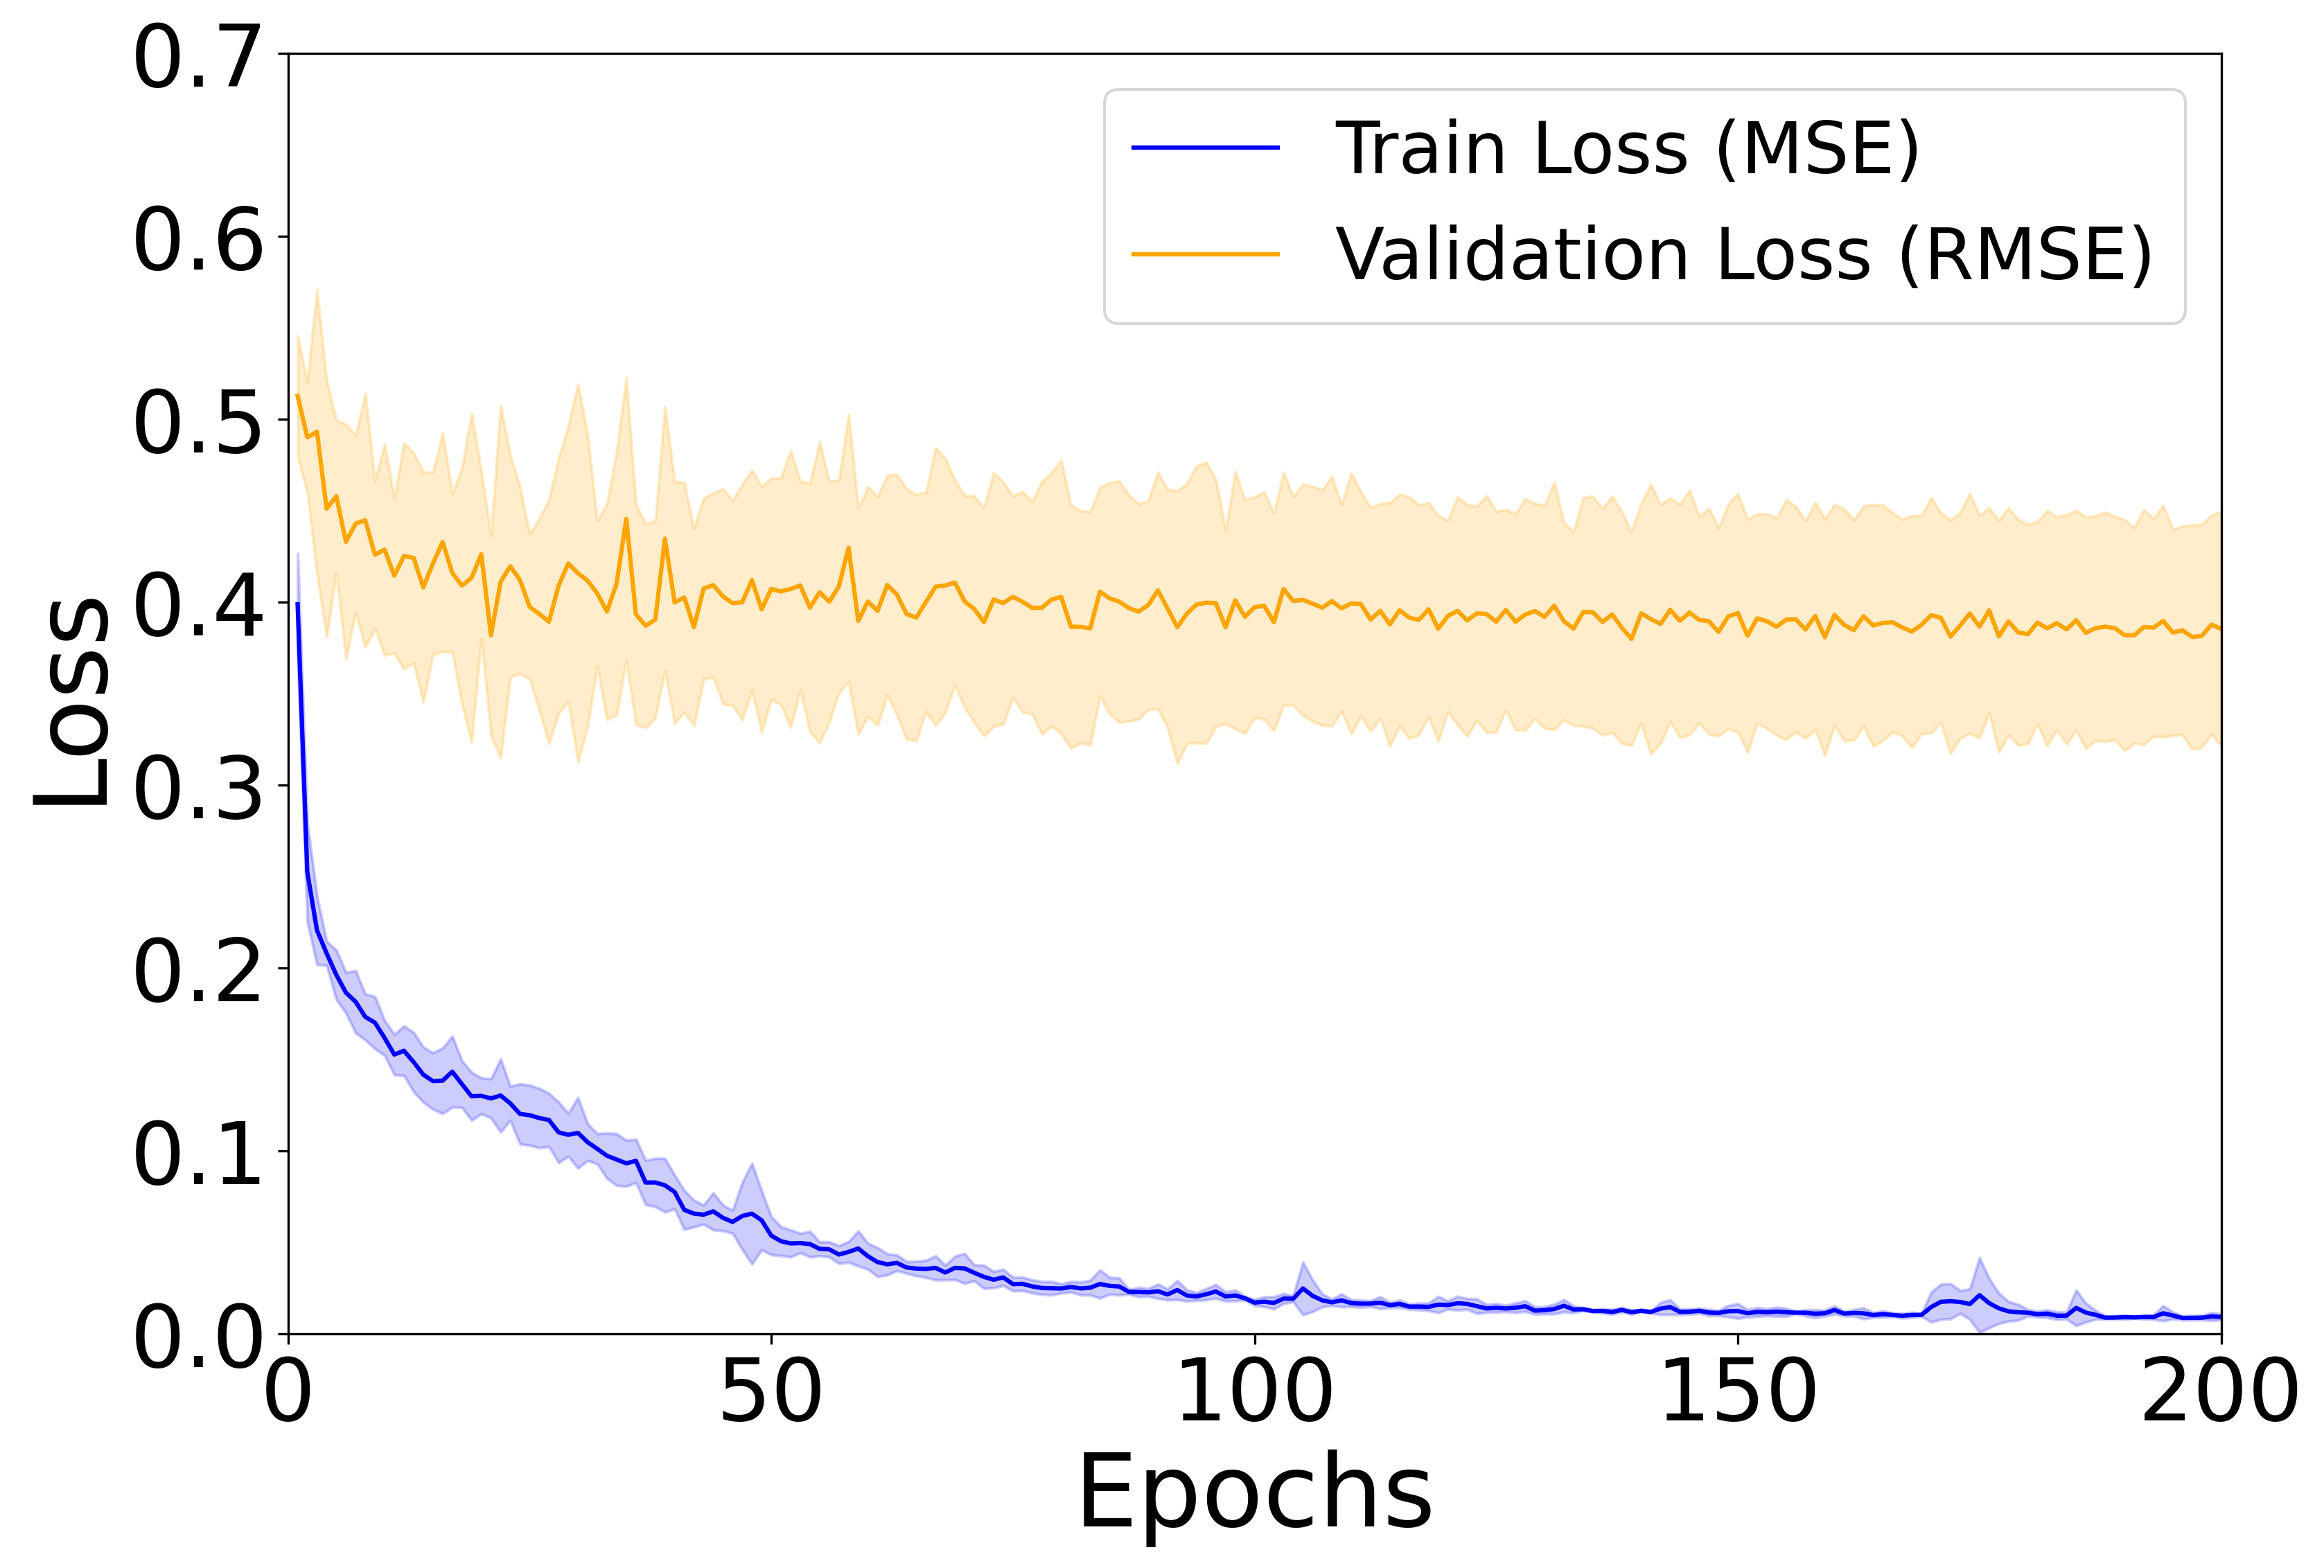

In [25]:
# --- Plot Average Loss Curves ---
plt.figure(figsize=(12, 8),dpi=300)

max_epochs_run = max(len(losses) for losses in all_val_losses_cv) if all_val_losses_cv else args.epochs

padded_train_losses = [l + [np.nan]*(max_epochs_run - len(l)) for l in all_train_losses_cv]
padded_val_losses = [l + [np.nan]*(max_epochs_run - len(l)) for l in all_val_losses_cv_rmse] #all_val_losses_cv]

avg_train_loss = np.nanmean(padded_train_losses, axis=0)
std_train_loss = np.nanstd(padded_train_losses, axis=0)
avg_val_loss = np.nanmean(padded_val_losses, axis=0)
std_val_loss = np.nanstd(padded_val_losses, axis=0)

epochs_axis = range(1, max_epochs_run + 1)

plt.plot(epochs_axis, avg_train_loss, label='Train Loss (MSE)', color='blue')
plt.fill_between(epochs_axis, avg_train_loss - std_train_loss, avg_train_loss + std_train_loss, color='blue', alpha=0.2)

plt.plot(epochs_axis, avg_val_loss, label=f'Validation Loss (RMSE)', color='orange')
plt.fill_between(epochs_axis, avg_val_loss - std_val_loss, avg_val_loss + std_val_loss, color='orange', alpha=0.2)

#plt.title(f'Average Training & Validation Loss ({k_folds}-Fold CV)', fontsize=25)
plt.xlabel('Epochs', fontsize=35)
plt.ylabel('Loss', fontsize=35)
plt.legend(fontsize=25)
#plt.grid(True)
plt.xlim(0, max_epochs_run)
min_loss_val = np.nanmin(avg_val_loss - std_val_loss) if not np.all(np.isnan(avg_val_loss)) else 0
max_loss_val = np.nanmax(avg_val_loss + std_val_loss) if not np.all(np.isnan(avg_val_loss)) else 1
min_loss_train = np.nanmin(avg_train_loss - std_train_loss) if not np.all(np.isnan(avg_train_loss)) else 0
max_loss_train = np.nanmax(avg_train_loss + std_train_loss) if not np.all(np.isnan(avg_train_loss)) else 1
plt.ylim(0, 0.7)

# increase font size of ticks
plt.tick_params(axis='both', which='major', labelsize=30)
plt.savefig('../Figures/GCN_tmqm_kfold-cv.png', transparent=True, bbox_inches='tight')